In [1]:
# Digit recognition using deep learning: Feed-forward Multi-layer perceptron
#Problem: https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits
# Identify the digit in given images. We have total 70,000 images, out of which 49,000 are part of train 
#images with the label of digit and rest 21,000 images are unlabeled (known as test images).
#import matplotlib as plt
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
%pylab inline

C:\Miniconda2\envs\tensorflow_env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Initialize random seed
seed=128
rng=np.random.RandomState(seed)

In [3]:
root_dir=os.path.abspath('..\..')
os.path.exists(root_dir)

True

In [4]:
train=pd.read_csv(os.path.join(root_dir,'Jupyter\Digit_recognition-deep learning\Train','train.csv'))
test=pd.read_csv('Test.csv')
Sample_submission=pd.read_csv('Sample_Submission.csv')

In [5]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [6]:
test.head()

,filename
0,49000.png
1,49001.png
2,49002.png
3,49003.png
4,49004.png


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 2 columns):
filename    49000 non-null object
label       49000 non-null int64
dtypes: int64(1), object(1)
memory usage: 765.7+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 1 columns):
filename    21000 non-null object
dtypes: object(1)
memory usage: 164.1+ KB


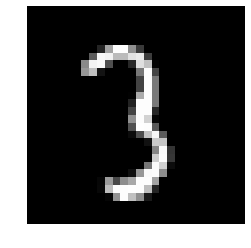

In [9]:
# Example of a random input file
img_name=rng.choice(train.filename)
filepath=os.path.join(root_dir,'Jupyter\Digit_recognition-deep learning\Train','Images','train',img_name)
img=imread(filepath)
pylab.imshow(img,cmap='gray')
pylab.axis('off')
pylab.show()

In [10]:
#Creating numerical representations of train and test data
temp=[]
for img_name in train.filename:
    imagepath=os.path.join(root_dir,'Jupyter\Digit_recognition-deep learning\Train','Images','train',img_name)
    img=imread(imagepath)
    img=img.astype('float32')
    temp.append(img)
train_x=np.stack(temp)

In [11]:
temp=[]
for img_name in test.filename:
    imagepath=os.path.join(root_dir,'Jupyter\Digit_recognition-deep learning\Train','Images','test',img_name)
    img=imread(imagepath)
    img=img.astype('float32')
    temp.append(img)
test_x=np.stack(temp)

In [14]:
# Spliting training data in training+validation data in 70:30 ratio
split_size=int(train_x.shape[0]*0.7)
train_x, val_x= train_x[:split_size], train_x[split_size:]
train_y, val_y= train.label.values[:split_size], train.label.values[split_size:]

In [15]:
# Convert label to one-hot vectors
def dense_to_one_hot(labels_dense,num_classes=10):
    num_labels=labels_dense.shape[0]
    index_offset=np.arange(num_labels)*num_classes
    label_one_hot=np.zeros((num_labels,num_classes))
    label_one_hot.flat[index_offset+labels_dense.ravel()]=1
    return label_one_hot

In [16]:
#Normalize by max value
def preproc(unclean_batch_x):
    return unclean_batch_x/unclean_batch_x.max()

In [17]:
# create random samples batch
def batch_creator(batch_size,dataset_length,dataset_name):
    batch_mask=rng.choice(dataset_length,batch_size)
    batch_x=eval(dataset_name+'_x')[[batch_mask]].reshape(-1,input_num_units)
    batch_x=preproc(batch_x)
    if dataset_name=='train':
        batch_y=eval(dataset_name).ix[batch_mask,'label'].values
        batch_y=dense_to_one_hot(batch_y)
    return batch_x, batch_y

In [43]:
# Setting up the variables
input_num_units=28*28*4
hidden_num_units=500
output_num_units=10

#define placeholders
x=tf.placeholder(tf.float32,[None,input_num_units])
y=tf.placeholder(tf.float32,[None,output_num_units])

epochs=5
batch_size=128
learning_rate=0.01

weights={
    'hidden':tf.Variable(tf.random_normal([input_num_units,hidden_num_units],seed=seed)),
    'output':tf.Variable(tf.random_normal([hidden_num_units,output_num_units],seed=seed))
}
bias={
    'hidden':tf.Variable(tf.random_normal([hidden_num_units],seed=seed)),
    'output':tf.Variable(tf.random_normal([output_num_units],seed=seed))
}

In [44]:
#Creating the neural network computational graph
hidden_layer=tf.add(tf.matmul(x,weights['hidden']),bias['hidden'])
hidden_layer=tf.nn.relu(hidden_layer)

output_layer=tf.add(tf.matmul(hidden_layer,weights['output']),bias['output'])

In [45]:
# Cost function: Cross entropy loss using softmax
Cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer,labels=y))

In [46]:
# Optimization function: Adam optimizer for gradient descent algorithm
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(Cost)

In [48]:
#initialize the variables
init=tf.initializers.global_variables()

In [49]:
with tf.Session() as sess:
    sess.run(init)
    #Training the neural network
    for epoch in range(epochs):
        avg_cost=0
        total_batch=int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y=batch_creator(batch_size,train_x.shape[0],'train')
            _, c=sess.run([optimizer, Cost], feed_dict= {x: batch_x, y: batch_y})
            avg_cost+=c/total_batch
        print ('Epoch:',epoch+1,'Cost:',avg_cost)
    print('Training Complete.')
    #Finding prediction on validation set
    pred_temp=tf.equal(tf.argmax(output_layer,1),tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(pred_temp,"float"))
    print('Accuracy on Validation dataset:',accuracy.eval({x: val_x.reshape(-1,input_num_units),y: dense_to_one_hot(val_y)}))
    predict=tf.argmax(output_layer,1)
    pred=predict.eval({x:test_x.reshape(-1,input_num_units)})

C:\Miniconda2\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
C:\Miniconda2\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


Epoch: 1 Cost: 33.71544515961754
Epoch: 2 Cost: 7.1184019811490495
Epoch: 3 Cost: 4.033201471439206
Epoch: 4 Cost: 2.5772221841608247
Epoch: 5 Cost: 1.9698961166426046
Training Complete.
Accuracy on Validation dataset: 0.9440136


Prediction is: 5


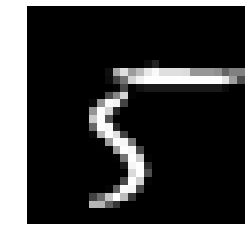

In [50]:
# Checking prdiction on one test case
img_name=rng.choice(test.filename)
filepath=os.path.join(root_dir,'Jupyter\Digit_recognition-deep learning\Train','Images','test',img_name)
img=imread(filepath)
test_index=int(img_name.split('.')[0])-49000
print('Prediction is:', pred[test_index])
pylab.imshow(img,cmap='gray')
pylab.axis('off')
pylab.show()

In [51]:
submission=test
submission['label']=pred
submission
submission.to_csv('Submission.csv',index=False)
#Final score: 0.945